# Data Preprocessing 

This notebook focuses on preprocessing the data into a format useable for later stages of the project.

## Dataset Notes
- I will only be using watch data in this project.
- Only 4 activities will be used:
    - Walking (A)
    - Jogging (B)
    - Standing (E)
    - Sitting (D)
- There are 51 subjects in the study. All 51 people will be used.

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.fft import fft


## Fetching Data, formatted as Pandas DF

In [2]:
wisdm_path = 'scratch/network/jr8867/wisdm-dataset'
watch_raw_path = 'raw/watch'

def process_subject_activity_sensor(subject, activity_code, sensor):
    """
    Returns a dataframe of the processed data for a given subject and sensor. 
    Filtered to only include the specified activities.

    Args:
        subject (int): The subject number to process. (0-50).
        activity_code (str): The activity code to filter the data by.
        sensor (str): The sensor to process. ('accel', 'gyro').

    Returns:
        pd.DataFrame: A dataframe of the processed data.
    """

    if sensor == 'accel':
        data_path = f'/{wisdm_path}/{watch_raw_path}/accel'
    elif sensor == 'gyro':
        data_path = f'/{wisdm_path}/{watch_raw_path}/gyro'

    subject_file = f'data_{1600+subject}_{sensor}_watch.txt'
    df = pd.read_csv(os.path.join(data_path, subject_file), header=None, names=["subject", "activity", "timestamp", "x", "y", "z"])
    
    # Trim trailing semicolon
    df['z'] = df['z'].str.rstrip(';')

    filtered_df = df[df['activity'] == activity_code]
    return filtered_df

def process_subject_activity(subject, activity_code):
    """
    Combines accel and gyro data for a given subject and activity.

    Args:
        subject (int): The subject number to process. (0-50).
        activity_code (str): The activity code to filter the data by.

    Returns:
        pd.DataFrame: A dataframe of the combined data.
    """
    accel_df = process_subject_activity_sensor(subject, activity_code, 'accel')
    gyro_df = process_subject_activity_sensor(subject, activity_code, 'gyro')

    accel_df.rename(columns={'x': 'ax', 'y': 'ay', 'z': 'az'}, inplace=True)
    gyro_df.rename(columns={'x': 'gx', 'y': 'gy', 'z': 'gz'}, inplace=True)

    combined_df = pd.merge(accel_df, gyro_df, on=['subject', 'activity', 'timestamp'], how='outer')
    combined_df.dropna(inplace=True)
    
    return combined_df

def process_subject(subject: int, activities: list):
    combined_df = pd.concat([process_subject_activity(subject, activity) for activity in activities])
    return combined_df

def process_all(subjects, activities: list):
    combined_df = pd.concat([process_subject(subject, activities) for subject in subjects])

    # Convert to float
    combined_df['ax'] = combined_df['ax'].astype(float)
    combined_df['ay'] = combined_df['ay'].astype(float)
    combined_df['az'] = combined_df['az'].astype(float)
    combined_df['gx'] = combined_df['gx'].astype(float)
    combined_df['gy'] = combined_df['gy'].astype(float)
    combined_df['gz'] = combined_df['gz'].astype(float)

    # Convert to int
    combined_df['timestamp'] = combined_df['timestamp'].astype(float) / 1000000
    combined_df['timestamp'] = combined_df['timestamp'].astype(int)

    return combined_df

In [3]:
df = process_all(range(51), ['A', 'B', 'D', 'E'])

### Save to CSV for later use

In [4]:
processed_watch_path = f'/{wisdm_path}/processed'
df.to_csv(os.path.join(processed_watch_path, 'processed_watch_data.csv'), index=False)

# Segmented Data for Training

- We want to turn the data into segments such that we can train on these segments.
- For each training instance, I will standardize them to be 10 seconds. 
    - I will have them overlapping by segmenting with a stride of 50%, effectively doubling our training data.

In [5]:
# Load the data from the processed CSV file
processed_watch_path = f'/{wisdm_path}/processed'
df = pd.read_csv(os.path.join(processed_watch_path, 'processed_watch_data.csv'))

In [6]:
segmented_watch_path = f'/{wisdm_path}/segmented'

# Create the directory if it doesn't exist
if not os.path.exists(segmented_watch_path):
    os.makedirs(segmented_watch_path)
    print(f"Created directory: {segmented_watch_path}")
else:
    print(f"Directory already exists: {segmented_watch_path}")


Directory already exists: /scratch/network/jr8867/wisdm-dataset/segmented


In [10]:
import os
import pandas as pd
from tqdm import tqdm

def create_segments(df, window_size=10):
    """
    Create fixed-length segments from time series data without overlapping windows,
    now considering timestamps in microseconds instead of milliseconds.
    
    Args:
        df (pd.DataFrame): DataFrame containing the time series data.
        window_size (int): Size of each segment in seconds.
    
    Returns:
        list: List of segment DataFrames.
    """
    segments = []
    segment_id = 0  # Global segment ID counter to ensure uniqueness across all segments
    
    # Group by subject and activity
    groups = df.groupby(['subject', 'activity'])
    for (subject, activity), group in tqdm(groups, desc='Processing groups'):
        # Sort by timestamp to ensure chronological order
        group = group.sort_values('timestamp')
        
        # Initialize the start time for the first segment
        start_time = group['timestamp'].min()
        segment = pd.DataFrame()  # Initialize an empty DataFrame for the current segment
        
        for index, row in group.iterrows():
            # If the segment is empty, set the start time
            if segment.empty:
                segment = row.to_frame().T
                start_time = row['timestamp']
                continue
            
            # Check if adding the current row exceeds the window size
            if (row['timestamp'] - start_time) < (window_size * 1000):  # milliseconds
                segment = pd.concat([segment, row.to_frame().T])  # Use pd.concat instead of append
            else:
                # Store the completed segment with a unique segment ID
                segment['segment_id'] = segment_id
                
                segments.append(segment)
                segment_id += 1  # Increment the global segment ID
                
                # Start a new segment
                segment = row.to_frame().T
                start_time = row['timestamp']  # Update the start time for the new segment
        
        # Check if there's a remaining segment to add
        if not segment.empty:
            # Only save the segment if it's a complete window (10 seconds)
            if (segment['timestamp'].max() - segment['timestamp'].min()) >= (window_size * 1000):
                segment['segment_id'] = segment_id
                
                # Save the segment to a file
                segment_filename = f"segment_{subject}_{activity}_{segment_id}.csv"
                segment.to_csv(os.path.join(segmented_watch_path, segment_filename), index=False)
                
                segments.append(segment)
                segment_id += 1  # Increment the global segment ID
    
    return segments


In [11]:
# Assuming df is already defined and contains the necessary time series data
segments = create_segments(df)  # Generate segments using the function

# Store the segments in a variable or save to a file
segments_df = pd.concat(segments, ignore_index=True)  # Combine all segments into a single DataFrame
segments_df.to_csv(os.path.join(segmented_watch_path, 'segments_output.csv'), index=False)  # Save the segments to a CSV file

Processing groups: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 202/202 [04:01<00:00,  1.20s/it]


# Extracting Features from Segmented Data

We will be extracting:
- Means
- Variances
- FFT Data

from each segment

In [23]:
# Load the segments DataFrame from the CSV file
segments_df = pd.read_csv(os.path.join(segmented_watch_path, 'segments_output.csv'))
# Display the loaded DataFrame to verify
segments_df

,subject,activity,timestamp,ax,ay,az,gx,gy,gz,segment_id
0,1600,A,90426757,4.972757,-0.158317,6.696732,0.314944,-1.022277,-0.309962,0
1,1600,A,90426807,3.253720,-0.191835,6.107758,0.387382,-0.618541,-0.048972,0
2,1600,A,90426856,2.801216,-0.155922,5.997625,0.070999,-0.209480,-0.195978,0
3,1600,A,90426906,3.770868,-1.051354,7.731027,0.037975,0.254976,-0.156563,0
4,1600,A,90426955,4.661511,0.169689,9.684695,0.073129,0.719431,-0.001035,0
...,...,...,...,...,...,...,...,...,...,...
716420,1650,E,2425520963,8.508694,-2.731934,3.818153,0.026534,-0.016976,-0.002532,3355
716421,1650,E,2425521013,8.482357,-2.763058,3.894767,0.022273,-0.023367,-0.008924,3355
716422,1650,E,2425521063,8.508694,-2.736722,3.863643,0.029730,-0.029759,-0.006793,3355
716423,1650,E,2425521113,8.527847,-2.712780,3.887585,0.014816,-0.022302,-0.000402,3355


In [31]:
# Define a function to extract features from each segment
def extract_features(group):
    # Calculate basic statistical features for accelerometer and gyroscope data
    features = {
        'subject': group['subject'].iloc[0],
        'activity': group['activity'].iloc[0]
    }
    
    # Mean values
    features['ax_mean'] = group['ax'].mean()
    features['ay_mean'] = group['ay'].mean()
    features['az_mean'] = group['az'].mean()
    features['gx_mean'] = group['gx'].mean()
    features['gy_mean'] = group['gy'].mean()
    features['gz_mean'] = group['gz'].mean()
    
    # Variance values
    features['ax_var'] = group['ax'].var()
    features['ay_var'] = group['ay'].var()
    features['az_var'] = group['az'].var()
    features['gx_var'] = group['gx'].var()
    features['gy_var'] = group['gy'].var()
    features['gz_var'] = group['gz'].var()
    
    # Define the sampling frequency as 20 Hz
    sampling_freq = 20  # 20 Hz sampling frequency
    # Calculate FFT features for each axis
    for axis in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
        signal = group[axis].values
        fft_result = fft(signal)
        magnitude = np.abs(fft_result)
        freq_bins = np.fft.fftfreq(len(signal), d=1/sampling_freq)  # Assuming 20 Hz sampling frequency
        
        positive_freq_idx = np.where(freq_bins > 0)[0]
        positive_magnitude = magnitude[positive_freq_idx]
        
        if len(positive_magnitude) > 0:
            features[f'{axis}_dominant_freq'] = freq_bins[positive_freq_idx][np.argmax(positive_magnitude)]
            features[f'{axis}_energy'] = np.sum(positive_magnitude**2) / len(positive_magnitude)
            normalized_magnitude = positive_magnitude / np.sum(positive_magnitude)
            entropy = -np.sum(normalized_magnitude * np.log2(normalized_magnitude + 1e-10))
            features[f'{axis}_spectral_entropy'] = entropy
            
            # Extract first few frequency components
            num_components = min(5, len(positive_magnitude))
            for i in range(num_components):
                features[f'{axis}_fft_coef_{i}'] = positive_magnitude[i]
    
    return pd.DataFrame([features])  # Return as a DataFrame

# Group by segment_id and extract features
features_df = segments_df.groupby('segment_id').apply(extract_features)

# Reset index to make segment_id a column
features_df = features_df.reset_index(drop=True)

# Display the resulting features DataFrame
print(f"Extracted features from {len(features_df)} segments")

Extracted features from 3356 segments


In [33]:
features_df.to_csv(os.path.join(segmented_watch_path, 'segment_features.csv'), index=False)

# Cleaning Processed Watch Data

In [5]:
# Load the data from the processed CSV file
wisdm_path = 'scratch/network/jr8867/wisdm-dataset'
segmented_watch_path = f'/{wisdm_path}/segmented'
df = pd.read_csv(os.path.join(segmented_watch_path, 'segments_output.csv'))

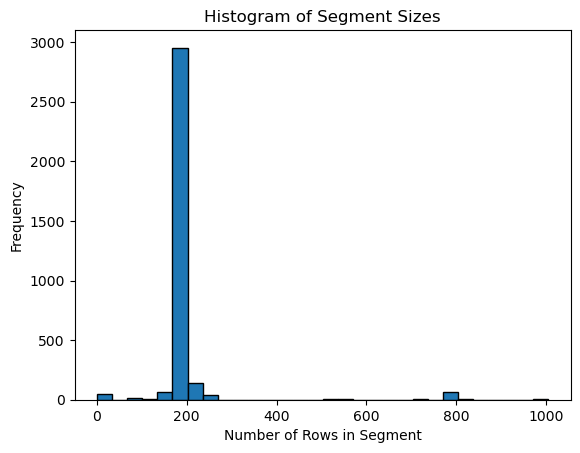

In [9]:
import matplotlib.pyplot as plt

grouped = df.groupby('segment_id')
segment_counts = [len(group) for segment_id, group in grouped]

plt.hist(segment_counts, bins=30, edgecolor='black')
plt.title('Histogram of Segment Sizes')
plt.xlabel('Number of Rows in Segment')
plt.ylabel('Frequency')
plt.show()

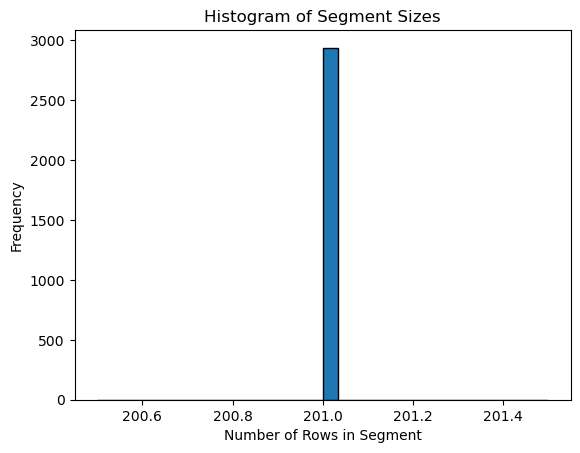

In [13]:
filtered_df = df.groupby('segment_id').filter(lambda x: len(x) == 201)

grouped = filtered_df.groupby('segment_id')
segment_counts = [len(group) for segment_id, group in grouped]

plt.hist(segment_counts, bins=30, edgecolor='black')
plt.title('Histogram of Segment Sizes')
plt.xlabel('Number of Rows in Segment')
plt.ylabel('Frequency')
plt.show()

In [16]:
for segment_id, group in filtered_df.groupby('segment_id'):
    
  
    # Convert the group to a numpy array of features
    X_segment = group[['ax', 'ay', 'az', 'gx', 'gy', 'gz']].to_numpy()
    
    # Get the activity label for this segment (should be consistent for the entire segment)
    y_segment = group['activity'].iloc[0]
    
    # Break if we haven't already created X and y
    if 'X' not in locals():
        X = np.array([X_segment])
        y = np.array([y_segment])
    else:
        X = np.vstack([X, [X_segment]])
        y = np.append(y, y_segment)


In [22]:
# Save X and y as NumPy arrays
np.save(os.path.join(segmented_watch_path, 'X_segments.npy'), X)
np.save(os.path.join(segmented_watch_path, 'y_segments.npy'), y)

print(f"Saved X with shape {X.shape} and y with shape {y.shape}")


Saved X with shape (2939, 201, 6) and y with shape (2939,)
